## Import necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

In [2]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] # Only use GPU 0 when existing multiple GPUs
    tf.config.experimental.set_memory_growth(gpu0, True) # Set the usage of GPU memory according to needs
    # The GPU memory usage could also be fixed (e.g. 4GB)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Binary alpha digits

In [4]:
dataset = tfds.load('binary_alpha_digits', split='train')

x_data, y_data = [], []
for i in dataset:
    a = i['image'].numpy()
    x_data.append(a.astype(np.float32))
    y_data.append(i['label'].numpy())
    
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, y_train, x_test, y_test = x_data[:1000], y_data[:1000], x_data[1000:], y_data[1000:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1000, 20, 16, 1), (1000,), (404, 20, 16, 1), (404,))

In [5]:
class NeuralNet(Model):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = layers.Conv2D(16, 3, padding='same', activation=tf.nn.relu)
        self.conv2 = layers.Conv2D(32, 3, padding='same', activation=tf.nn.relu)
        self.maxpool = layers.MaxPool2D()
        self.batch1 = layers.BatchNormalization()
        self.batch2 = layers.BatchNormalization()
        self.flat = layers.Flatten()
        self.fc1 = layers.Dense(256, activation=tf.nn.relu)
        self.fc2 = layers.Dense(64, activation=tf.nn.relu)
        self.out = layers.Dense(36)

    def call(self, x, is_training=False):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

In [6]:
model = NeuralNet()
model.build(input_shape=(1, 20, 16, 1))
model.summary()

Model: "neural_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  160       
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                        

In [7]:
# set optimizer and loss

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [8]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [9]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_minibatch = DataGenerator(x_train, y_train, 64)
test_minibatch = DataGenerator(x_test, y_test, 64)

In [10]:
# Training process
model = NeuralNet()

epochs = 100

for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_minibatch:
        train_step(images, labels)

    for test_images, test_labels in test_minibatch:
        test_step(test_images, test_labels)
    if epoch % 10 == 0:
        print(
          f'Epoch {epoch}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}, '
          f'Test Loss: {test_loss.result()}, '
          f'Test Accuracy: {test_accuracy.result() * 100}'
      )

/home/airi/anaconda3/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0, Loss: 3.261150360107422, Accuracy: 13.899999618530273, Test Loss: 3.5355422496795654, Test Accuracy: 17.079206466674805
Epoch 10, Loss: 0.056470539420843124, Accuracy: 97.5, Test Loss: 3.4033806324005127, Test Accuracy: 7.178217887878418
Epoch 20, Loss: 0.03555050492286682, Accuracy: 97.89999389648438, Test Loss: 2.189898729324341, Test Accuracy: 50.0
Epoch 30, Loss: 0.03698239475488663, Accuracy: 97.5999984741211, Test Loss: 0.9367073178291321, Test Accuracy: 71.03960418701172
Epoch 40, Loss: 0.03704993054270744, Accuracy: 97.5999984741211, Test Loss: 0.8746575713157654, Test Accuracy: 73.26732635498047
Epoch 50, Loss: 0.03535489737987518, Accuracy: 97.5999984741211, Test Loss: 0.9320019483566284, Test Accuracy: 72.27722930908203
Epoch 60, Loss: 0.033559054136276245, Accuracy: 97.5999984741211, Test Loss: 0.9599925875663757, Test Accuracy: 73.26732635498047
Epoch 70, Loss: 0.03546600416302681, Accuracy: 97.39999389648438, Test Loss: 0.9978030323982239, Test Accuracy: 73.01980

In [12]:
tf.saved_model.save(model, 'models/bad')

INFO:tensorflow:Assets written to: models/bad/assets


INFO:tensorflow:Assets written to: models/bad/assets


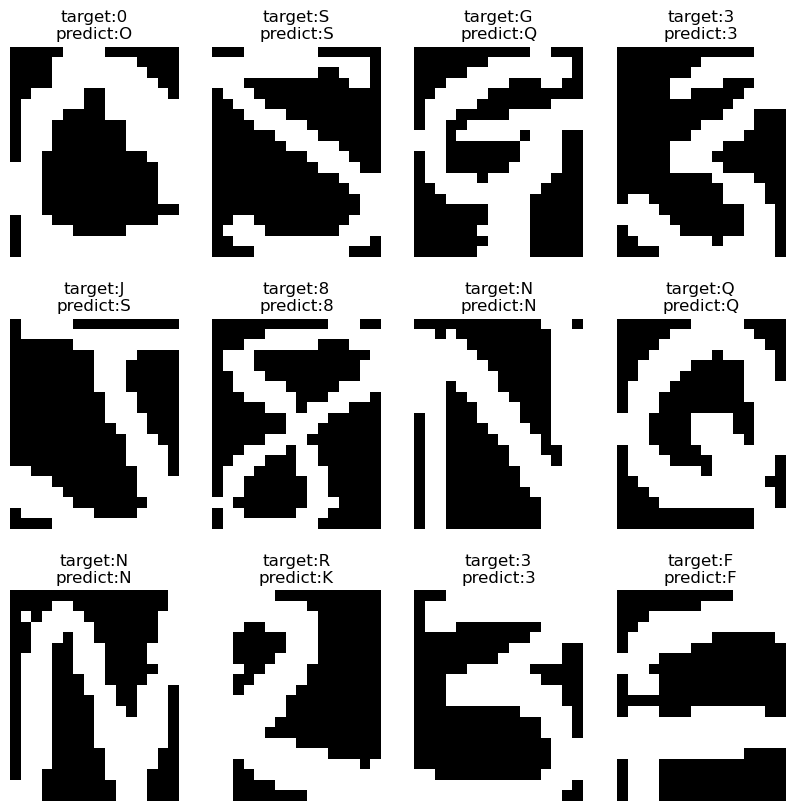

In [13]:
# test model with test dataset

classes = [str(i) for i in range(10)]
for i in range(65, 91):
    classes.append(chr(i))

# Visualize predictions.
import matplotlib.pyplot as plt
# Predict 5 images from validation set.
n_images = 12
test_images = x_test[:n_images]
predictions = model(test_images)
plt.figure(figsize=(10,10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3,4,i+1)
    plt.imshow(test_images[i], cmap='gray')
    plt.axis('off')
    plt.title('target:'+classes[y_test[i]]+'\n'+'predict:'+classes[np.argmax(predictions.numpy()[i])])

Prediction: S 8
Targets: J 8


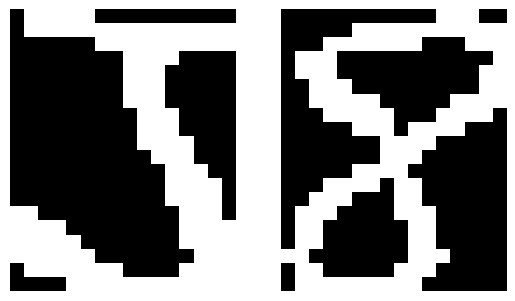

In [14]:
plt.subplot(121)
plt.imshow(x_test[4], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(x_test[5], cmap='gray')
plt.axis('off')

modelmb = tf.saved_model.load('models/bad')
pred = np.argmax(modelmb(x_test[4:6]), axis=1)
print("Prediction:", classes[pred[0]], classes[pred[1]])
print('Targets:', classes[y_test[4]], classes[y_test[5]])

## Deep_weeds

In [67]:
dataset = tfds.load('deep_weeds', split='train')

x_data, y_data = [], []
for i in dataset:
    a = i['image'].numpy()
    x_data.append(cv2.resize(a, (224, 224))/255.0)
    y_data.append(i['label'].numpy())
    
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, y_train, x_test, y_test = x_data[:15000], y_data[:15000], x_data[15000:], y_data[15000:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15000, 224, 224, 3), (15000,), (2509, 224, 224, 3), (2509,))

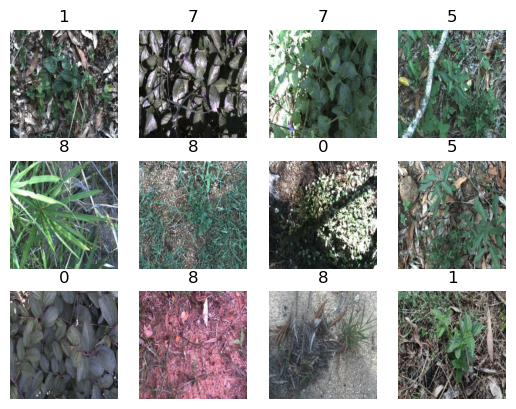

In [68]:
import matplotlib.pyplot as plt

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow((x_train[i]*255).astype(np.uint8))
    plt.title(y_train[i])
    plt.axis('off')

In [70]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 32)
test_gen = DataGenerator(x_test, y_test, 32)

In [71]:
# define model
class NN(Model):
    def __init__(self):
        super(NN, self).__init__()
        self.base_model = tf.keras.applications.ResNet50(weights="imagenet",
                                                         input_shape=(224, 224, 3),
                                                         include_top=False)
        self.base_model.trainable = False
        self.apool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(1024, activation=tf.nn.relu)
        self.fc2 = layers.Dense(128, activation=tf.nn.relu)
        self.out = layers.Dense(9, activation=tf.nn.softmax)
        
    def call(self, x, is_training=False):
        x = self.base_model(x)
        x = self.apool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [72]:
# create model and set optimizer, loss
model = NN()
model.build((1,224,224,3))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

model.summary()

Model: "nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             multiple                  2098176   
                                                                 
 dense_5 (Dense)             multiple                  131200    
                                                                 
 dense_6 (Dense)             multiple                  1161      
                                                                 
Total params: 25,818,249
Trainable params: 2,230,537
Non-trainable params: 23,587,712
__________________________________________

In [73]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [74]:
# Train process

epochs = 30

for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_gen:
        train_step(images, labels)

    for test_images, test_labels in test_gen:
        test_step(test_images, test_labels)
        
    print(
      f'Epoch {epoch}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
     )

/home/airi/anaconda3/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0, Loss: 1.6137912273406982, Accuracy: 52.02000045776367, Test Loss: 1.5292341709136963, Test Accuracy: 52.80988311767578
Epoch 1, Loss: 1.4961161613464355, Accuracy: 52.733333587646484, Test Loss: 1.4791239500045776, Test Accuracy: 52.132328033447266
Epoch 2, Loss: 1.4494836330413818, Accuracy: 52.92000198364258, Test Loss: 1.409348726272583, Test Accuracy: 52.3714599609375
Epoch 3, Loss: 1.4157955646514893, Accuracy: 52.93333435058594, Test Loss: 1.380409598350525, Test Accuracy: 52.570743560791016
Epoch 4, Loss: 1.3948557376861572, Accuracy: 53.17333221435547, Test Loss: 1.3675345182418823, Test Accuracy: 52.88959884643555
Epoch 5, Loss: 1.3787603378295898, Accuracy: 53.34000015258789, Test Loss: 1.3560372591018677, Test Accuracy: 53.2483024597168
Epoch 6, Loss: 1.3688781261444092, Accuracy: 53.380001068115234, Test Loss: 1.3514225482940674, Test Accuracy: 53.20845413208008
Epoch 7, Loss: 1.3593947887420654, Accuracy: 53.71999740600586, Test Loss: 1.3425631523132324, Test Accu

In [75]:
tf.saved_model.save(model, 'models/deepweeds')

INFO:tensorflow:Assets written to: models/deepweeds/assets


INFO:tensorflow:Assets written to: models/deepweeds/assets


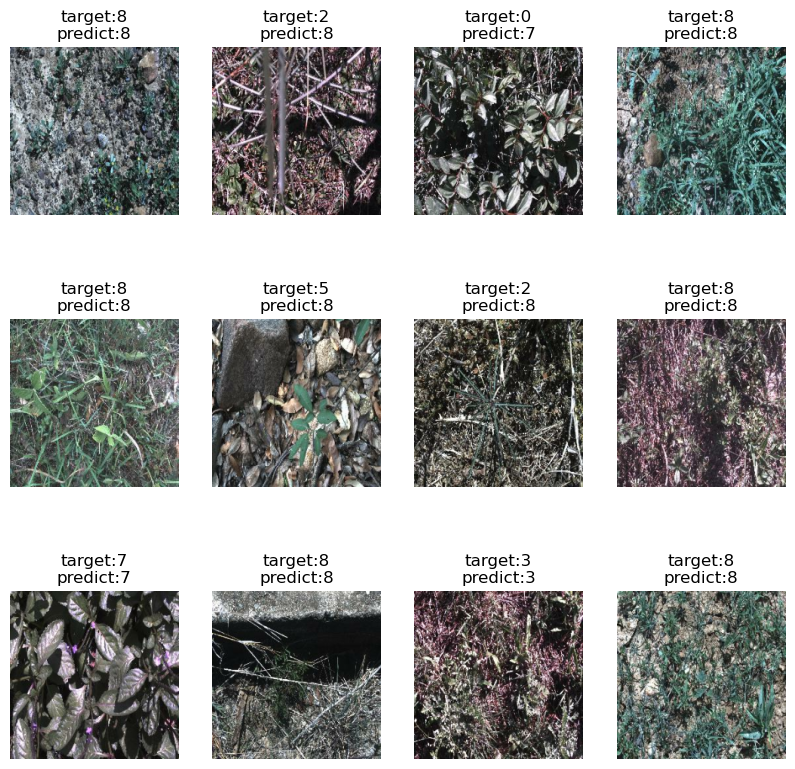

In [25]:
# test model with test dataset
# Visualize predictions.

import matplotlib.pyplot as plt
# Predict 12 images from validation set.
n_images = 12
test_images = x_test[:n_images]
predictions = model(test_images)
plt.figure(figsize=(10,10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3,4,i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title('target:'+str(y_test[i])+'\n'+'predict:'+str(np.argmax(predictions.numpy()[i])))

### Horses_or_humans

In [36]:
dataset = tfds.load('horses_or_humans')
train, test = dataset['train'], dataset['test']

x_train, y_train, x_test, y_test = [], [], [], []
for i in train:
    a = i['image'].numpy()/255.0
    x_train.append(cv2.resize(a, (224, 224)))
    y_train.append(i['label'].numpy())
    
for i in test:
    a = i['image'].numpy()/255.0
    x_test.append(cv2.resize(a, (224, 224)))
    y_test.append(i['label'].numpy())
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1027, 224, 224, 3), (1027,), (256, 224, 224, 3), (256,))

In [37]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 128)
test_gen = DataGenerator(x_test, y_test, 128)

In [38]:
class NN(Model):
    def __init__(self):
        super(NN, self).__init__()
        self.base_model = tf.keras.applications.MobileNet(weights="imagenet",
                                                         input_shape=(224, 224, 3),
                                                         include_top=False)
        self.base_model.trainable = False
        self.apool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(512, activation=tf.nn.relu)
        self.fc2 = layers.Dense(128, activation=tf.nn.relu)
        self.out = layers.Dense(1, activation=tf.nn.sigmoid)
        
    def call(self, x, is_training=False):
        x = self.base_model(x)
        x = self.apool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [39]:
model = NN()

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [40]:
epochs = 5

for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_gen:
        train_step(images, labels)

    for test_images, test_labels in test_gen:
        test_step(test_images, test_labels)
    print(
      f'Epoch {epoch}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}%, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}%'
     )

Epoch 0, Loss: 0.5502755641937256, Accuracy: 88.99707794189453%, Test Loss: 0.5038194060325623, Test Accuracy: 100.0%
Epoch 1, Loss: 0.5070217847824097, Accuracy: 99.90263366699219%, Test Loss: 0.5032869577407837, Test Accuracy: 100.0%
Epoch 2, Loss: 0.5057690143585205, Accuracy: 100.0%, Test Loss: 0.5032322406768799, Test Accuracy: 100.0%
Epoch 3, Loss: 0.5056436657905579, Accuracy: 100.0%, Test Loss: 0.5032413005828857, Test Accuracy: 100.0%
Epoch 4, Loss: 0.5056416392326355, Accuracy: 100.0%, Test Loss: 0.5032328367233276, Test Accuracy: 100.0%


In [41]:
tf.saved_model.save(model, 'models/horsehumans')

INFO:tensorflow:Assets written to: models/horsehumans/assets


INFO:tensorflow:Assets written to: models/horsehumans/assets


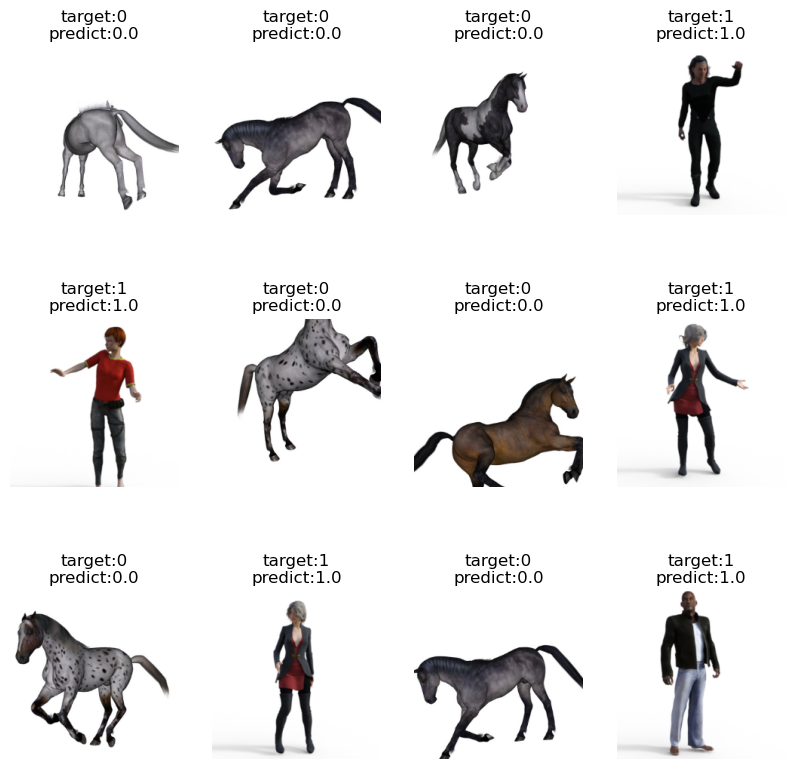

In [52]:
# test model with test dataset
# Visualize predictions.

import matplotlib.pyplot as plt
# Predict 12 images from validation set.
n_images = 12
test_images = x_test[:n_images]
predictions = model(test_images)
plt.figure(figsize=(10,10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3,4,i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title('target:'+str(y_test[i])+'\n'+'predict:'+str(np.round(predictions.numpy()[i, 0], 2)))

## Svhn_cropped

In [53]:
train = tfds.load('svhn_cropped', split='train')
extra = tfds.load('svhn_cropped', split='extra')

x_train, y_train, x_extra, y_extra = [], [], [], []
for i in train:
    a = i['image'].numpy()/255.0
    x_train.append(a)
    y_train.append(i['label'].numpy())
    
for i in extra:
    a = i['image'].numpy()/255.0
    x_extra.append(a)
    y_extra.append(i['label'].numpy())
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_extra = np.array(x_extra)
y_extra = np.array(y_extra)

x_train.shape, y_train.shape, x_extra.shape, y_extra.shape

((73257, 32, 32, 3), (73257,), (531131, 32, 32, 3), (531131,))

In [54]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_extra, y_extra, 128)
test_gen = DataGenerator(x_train, y_train, 128)

In [55]:
tf.keras.backend.clear_session()

class NN(Model):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = layers.Conv2D(8, 3, padding='same', activation=tf.nn.relu)
        self.pool = layers.MaxPooling2D(2)
        self.conv2 = layers.Conv2D(16, 3, padding='same', activation=tf.nn.relu)
        self.conv3 = layers.Conv2D(32, 3, padding='same', activation=tf.nn.relu)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation=tf.nn.relu)
        self.fc2 = layers.Dense(512, activation=tf.nn.relu)
        self.fc3 = layers.Dense(128, activation=tf.nn.relu)
        self.out = layers.Dense(10, activation=tf.nn.softmax)
        
    def call(self, x, is_training=False):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

model = NN()
model.build(input_shape=(1, 32, 32, 3))
model.summary()

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  224       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  1168      
                                                                 
 conv2d_2 (Conv2D)           multiple                  4640      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  2098176   
                                                                

In [56]:
optimizer = tf.keras.optimizers.Nadam()
loss_func = tf.losses.SparseCategoricalCrossentropy()

train_loss = tf.metrics.Mean(name='train_loss')
train_metric = tf.metrics.SparseCategoricalAccuracy(name='train_accuracy')

valid_loss = tf.metrics.Mean(name='valid_loss')
valid_metric = tf.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [57]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features,training = True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)

@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)

In [58]:
def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):

        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'

        tf.print(tf.strings.format(logs,
        (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
        tf.print("")

        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

train_model(model,train_gen,test_gen, 5)

Epoch=1,Loss:0.237138599,Accuracy:0.927210033,Valid Loss:0.35104984,Valid Accuracy:0.898753703

Epoch=2,Loss:0.100903891,Accuracy:0.971058,Valid Loss:0.341801733,Valid Accuracy:0.906507254

Epoch=3,Loss:0.0715802312,Accuracy:0.979490936,Valid Loss:0.3561185,Valid Accuracy:0.906125

Epoch=4,Loss:0.0541988164,Accuracy:0.984465241,Valid Loss:0.357192695,Valid Accuracy:0.908459246

Epoch=5,Loss:0.043196477,Accuracy:0.987413645,Valid Loss:0.410696685,Valid Accuracy:0.905688167



In [59]:
tf.saved_model.save(model, 'models/svhn')

INFO:tensorflow:Assets written to: models/svhn/assets


INFO:tensorflow:Assets written to: models/svhn/assets


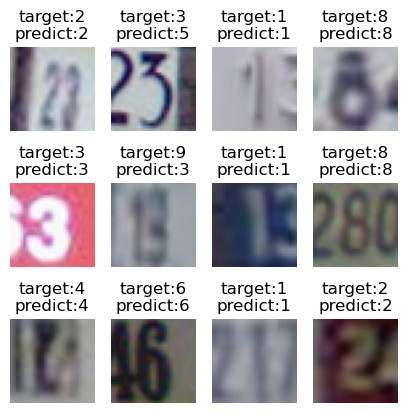

In [66]:
# test model with test dataset
# Visualize predictions.

import matplotlib.pyplot as plt
# Predict 12 images from validation set.
n_images = 12
test_images = x_train[100:100+n_images]
predictions = model(test_images)
plt.figure(figsize=(5,5))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3,4,i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title('target:'+str(y_train[i+100])+'\n'+'predict:'+str(np.argmax(predictions.numpy()[i])))